# Loan Eligibility Predictor 

In [26]:
# Dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path
from pprint import pprint
from utils import *
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report

### Data 

In [2]:
# Datasets 
train_data_path = Path("./dataset/train_extended.csv") 
test_data_path = Path("./dataset/test.csv") 
train_data = pd.read_csv(train_data_path, encoding='utf-8', index_col='Loan_ID')
test_data = pd.read_csv(test_data_path, encoding='utf-8', index_col='Loan_ID')

train_data = train_data.drop('Credit_History', axis=1)
test_data = test_data.drop('Credit_History', axis=1)

In [3]:
# Missing column in test_data
print(list(set(train_data.columns) - set(test_data.columns))[0])

Loan_Status


In [4]:
# DataFrame Shape Comparision
train_data.shape, train_data.dropna().shape

((6000, 11), (5649, 11))

In [5]:
df_NaN_Status(train_data)

Gender              	120/6000
Married             	 0/6000
Dependents          	 0/6000
Education           	 0/6000
Self_Employed       	120/6000
ApplicantIncome     	 0/6000
CoapplicantIncome   	 0/6000
LoanAmount          	120/6000
Loan_Amount_Term    	 0/6000
Property_Area       	 0/6000
Loan_Status         	 0/6000


### Data Fetch and Engineering

In [6]:
X_train, y_train, X_test = get_train_test_data(train_data, test_data)

In [7]:
X_train.dtypes

Gender                   int64
Married                  int64
Dependents               int64
Education                int64
Self_Employed            int64
ApplicantIncome        float64
CoapplicantIncome      float64
LoanAmount             float64
Loan_Amount_Term       float64
Property_Area            int64
Total_Income           float64
EMI                    float64
DTI                    float64
Debt_to_Income         float64
Income_Per_Capita      float64
Income_to_EMI_Ratio    float64
dtype: object

### Model (Random Forrest and Logistic Regression Models)

In [8]:
models = {
    'LogisticRegression': LogisticRegression(tol=0.0001, fit_intercept=True, verbose=False), 
    'RandomForrestClassifierParameterized': RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=4, min_samples_split=10, random_state=42), 
    'RandomForrestClassifierDefault': RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True, class_weight='balanced'), # Best performing
    'RandomForrestClassifierParloured': RandomForestClassifier(n_estimators=300, max_features=int(0.4 * len(X_train.columns)),
                                                            random_state=42, warm_start=True, class_weight='balanced', max_leaf_nodes=5) 
}
model = models['RandomForrestClassifierDefault']
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42,
                       warm_start=True)

### Hyperparameter tuning (for best model param selection)

In [9]:
# Testing different hyperparameters for best model selection
hyperparam_grid = {
    'n_estimators'      : [100, 200, 300],
    'max_depth'         : [None, 10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 4]
}

# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), hyperparam_grid, cv=5, scoring='f1')
# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)

# RECENT TESTED: 
# Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

### Model Evalutation (Regression Models)

In [10]:
# Cross Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

# Feature Importances df
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_ * 100
}).sort_values('importance', ascending=False, ignore_index=True)

print("\nFeature Importance: ")
print(feature_importance)


Cross-validation scores: [0.675      0.68083333 0.67333333 0.65833333 0.67083333]
Average CV score: 0.6716666666666666

Feature Importance: 
                feature  importance
0     CoapplicantIncome   11.432512
1       ApplicantIncome   11.120105
2     Income_Per_Capita   11.048560
3          Total_Income   10.143273
4        Debt_to_Income    9.525742
5   Income_to_EMI_Ratio    9.354026
6            LoanAmount    8.980561
7                   EMI    8.851377
8                   DTI    8.131918
9         Property_Area    2.399562
10           Dependents    2.325782
11            Education    1.617551
12              Married    1.577100
13               Gender    1.396273
14        Self_Employed    1.187252
15     Loan_Amount_Term    0.908405


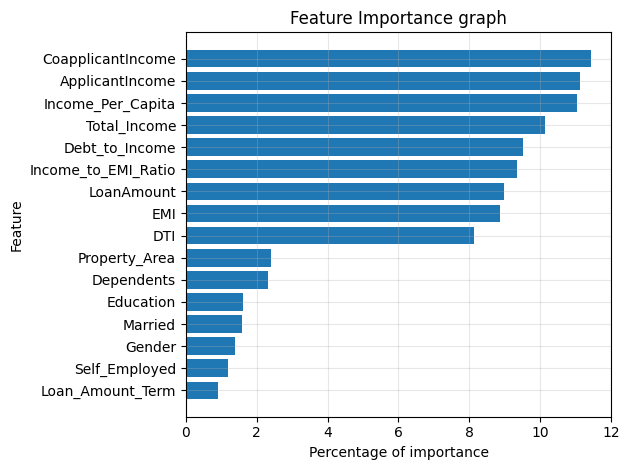

In [11]:
# Plot feature importances 
_feature_importance = feature_importance.sort_values(by='importance', ascending=True)
plt.barh(_feature_importance['feature'], _feature_importance['importance'])
plt.title("Feature Importance graph")
plt.xlabel("Percentage of importance")
plt.ylabel("Feature")
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [36]:
# F1 Score
y_pred = model.predict(X_train)
f1 = f1_score(y_true=y_train, y_pred=y_pred)

print("F1 Score: ", f1)

# Confusion matrix
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
print("\nConfustion Matrix: \t")
print(cm)

cm_ravel_cpms = ['True negative', 'False Positive', 'False negative', 'True Positive'] 


pd.DataFrame({
    'Component': cm_ravel_cpms, 
    'Value' : [0, 366, 0, 834]
})

F1 Score:  1.0

Confustion Matrix: 	
[[1843    0]
 [   0 4157]]


,Component,Value
0,True negative,0
1,False Positive,366
2,False negative,0
3,True Positive,834


In [19]:
# Classfication report 
print(classification_report(y_true=y_train, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1843
           1       1.00      1.00      1.00      4157

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



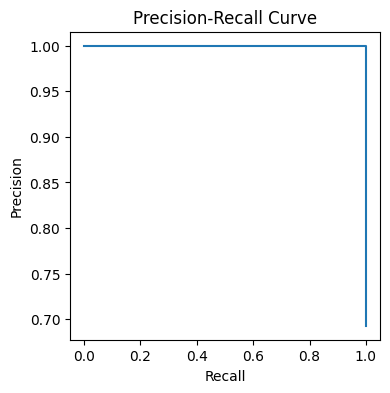

ROC-AUC Score: 1.0


In [14]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_train, model.predict_proba(X_train)[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
print(f'ROC-AUC Score: {roc_auc}')

Loan_Approval_Status
Y    97.275204
N     2.724796
Name: proportion, dtype: float64


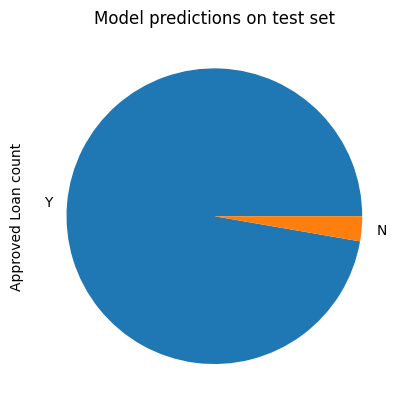

In [15]:
# Test predicitons with test dataset 
test_predictions = model.predict(X_test)
test_predictions_proba = model.predict_proba(X_test)

# Save predictions
predictions_df = pd.DataFrame({
    'Loan_ID': test_data.index,
    'Loan_Approval_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions],
    'Confidence (%)': test_predictions_proba[:, 1]
})

print(predictions_df['Loan_Approval_Status'].value_counts(normalize=True) * 100)

predictions_pie = predictions_df['Loan_Approval_Status'].value_counts()\
    .plot(kind='pie', title='Model predictions on test set', ylabel="Approved Loan count")

### Test on sample data

In [16]:
# Example usage
sample_input = {
    'Gender'            : 'Male', 
    'Married'           : 'Yes', 
    'Dependents'        : '1',
    'Education'         : 'Graduate', 
    'Self_Employed'     : 'Yes',
    'ApplicantIncome'   : 50000, 
    'CoapplicantIncome' : 1000,
    'LoanAmount'        : 1000, 
    'Loan_Amount_Term'  : 60,
    'Property_Area'     : 'Rural'
}
status, confidence = predict_loan_eligibility(model, sample_input)
print(f"Loan Status: {status}, Confidence of approval: {confidence:.2%}")

Loan Status: Y, Confidence of approval: 69.00%


### Save the model 

In [17]:
save_model(model=model, fp="/Users/samarth/Programming/Loaner/model/loanPredictorModel.pkl")